# First task

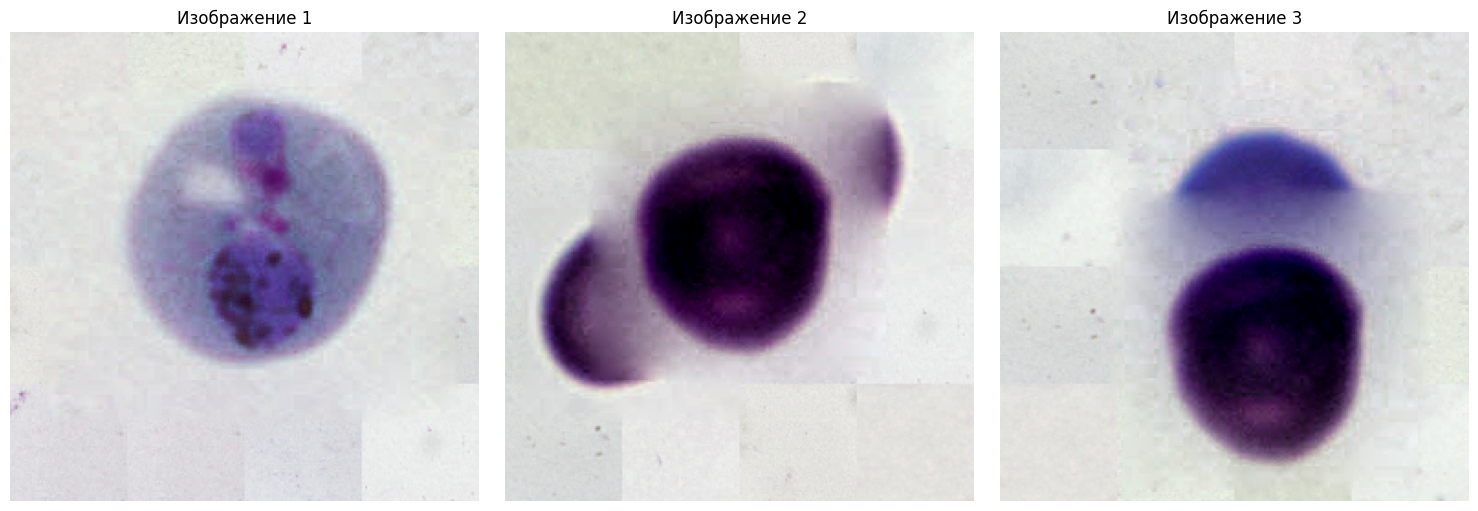


Сравнение изображений
          SSIM       MSE
.png  1.000000  0.000000
.jpg  0.988108  1.298019
.bmp  1.000000  0.000000


In [9]:
import cv2
import numpy as np
import random
import os
from glob import glob
import matplotlib.pyplot as plt
from skimage.metrics import structural_similarity as ssim
from sklearn.metrics import mean_squared_error
import pandas as pd

class ImageGenerator:
    def __init__(self, image_size=(256, 256), patch_dir="blood_cells_dataset/fon", cell_patch_dir="blood_cells_dataset/patch"):
        self.image_size = image_size
        self.patch_dir = patch_dir
        self.cell_patch_dir = cell_patch_dir
        self.patch_size = (64, 64)
        self.num_cells_range = (1, 5)
    
    def create_background_from_patches(self):
        background = np.zeros((self.image_size[1], self.image_size[0], 3), dtype=np.uint8)
        patch_files = glob(os.path.join(self.patch_dir, "*.png"))
        if not patch_files:
            raise FileNotFoundError(f"Не найдены изображения в директории {self.patch_dir}")
        
        num_patches_x = self.image_size[0] // self.patch_size[0]
        num_patches_y = self.image_size[1] // self.patch_size[1]
        
        for i in range(num_patches_y):
            for j in range(num_patches_x):
                patch = cv2.imread(random.choice(patch_files), cv2.IMREAD_COLOR)
                if patch is None:
                    continue
                patch = cv2.resize(patch, self.patch_size)
                background[i * self.patch_size[1]:(i + 1) * self.patch_size[1], j * self.patch_size[0]:(j + 1) * self.patch_size[0]] = patch
        
        return background
    
    def place_cell(self, background, cell):
        bg_h, bg_w, _ = background.shape
        cell_h, cell_w, _ = cell.shape
        mask = 255 * np.ones((cell_h, cell_w), dtype=np.uint8)
        x = random.randint(0, bg_w - cell_w)
        y = random.randint(0, bg_h - cell_h)
        center = (x + cell_w // 2, y + cell_h // 2)
        return cv2.seamlessClone(cell, background, mask, center, cv2.NORMAL_CLONE)
    
    def generate_image(self):
        background = self.create_background_from_patches()
        clean_image = background.copy()
        num_cells = random.randint(self.num_cells_range[0], self.num_cells_range[1])
        cell_files = glob(os.path.join(self.cell_patch_dir, "*.png"))
        
        for _ in range(num_cells):
            cell = cv2.imread(random.choice(cell_files), cv2.IMREAD_COLOR)
            if cell is None:
                continue
            clean_image = self.place_cell(clean_image, cell)
        
        return clean_image
    
    def generate_and_save_images(self, output_dir="generated_images", num_images=3, image_formats=(".png", ".jpg", ".bmp")):
        os.makedirs(output_dir, exist_ok=True)
        generated_images = []
        
        for i in range(num_images):
            clean_image = self.generate_image()
            generated_images.append(clean_image)
            for format in image_formats:
                filename = os.path.join(output_dir, f"clean_image_{i}{format}")
                if format == ".jpg":
                    cv2.imwrite(filename, clean_image, [int(cv2.IMWRITE_JPEG_QUALITY), 100])
                else:
                    cv2.imwrite(filename, clean_image)
        
        self.display_images(generated_images)
        self.compare_images(output_dir, num_images, image_formats)
    
    def display_images(self, images):
        plt.figure(figsize=(15, 5))
        for i, img in enumerate(images):
            plt.subplot(1, len(images), i + 1)
            plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
            plt.title(f"Изображение {i+1}")
            plt.axis('off')
        plt.tight_layout()
        plt.show()
    
    def compare_images(self, output_dir, num_images, image_formats):
        print("\nСравнение изображений")
        results = {fmt: {"SSIM": [], "MSE": []} for fmt in image_formats}
        
        for i in range(num_images):
            original_image = cv2.imread(os.path.join(output_dir, f"clean_image_{i}.png"))
            original_image = cv2.cvtColor(original_image, cv2.COLOR_BGR2RGB)
            
            for fmt in image_formats:
                filename = os.path.join(output_dir, f"clean_image_{i}{fmt}")
                loaded_image = cv2.imread(filename)
                if loaded_image is None:
                    print(f"Ошибка загрузки изображения: {filename}")
                    continue
                loaded_image = cv2.cvtColor(loaded_image, cv2.COLOR_BGR2RGB)
                if original_image.shape == loaded_image.shape:
                    ssim_score = ssim(original_image, loaded_image, channel_axis=-1, data_range=loaded_image.max() - loaded_image.min())
                    mse_score = mean_squared_error(original_image.flatten(), loaded_image.flatten())
                else:
                    ssim_score = np.nan
                    mse_score = np.nan
                results[fmt]["SSIM"].append(ssim_score)
                results[fmt]["MSE"].append(mse_score)
        
        table_data = {fmt: {"SSIM": np.nanmean(results[fmt]["SSIM"]), "MSE": np.nanmean(results[fmt]["MSE"])} for fmt in image_formats}
        df = pd.DataFrame.from_dict(table_data, orient="index")
        print(df)

# Использование класса
generator = ImageGenerator()
generator.generate_and_save_images()


# Second task

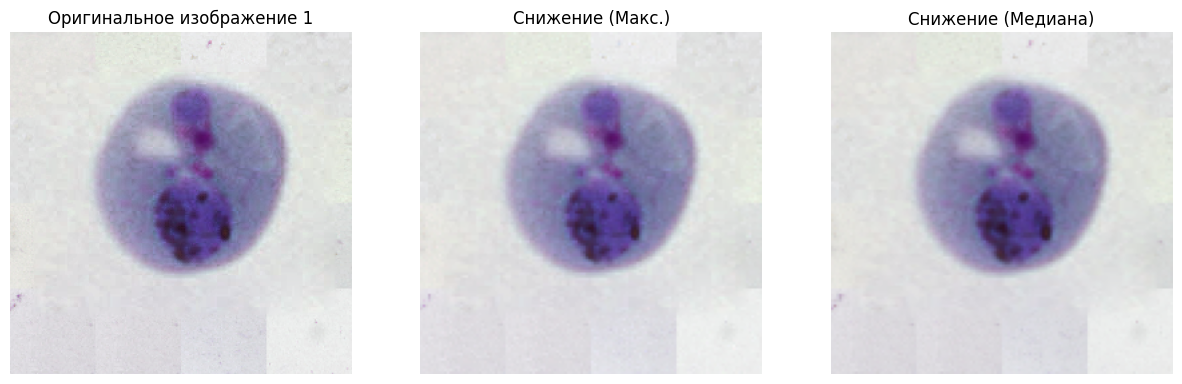

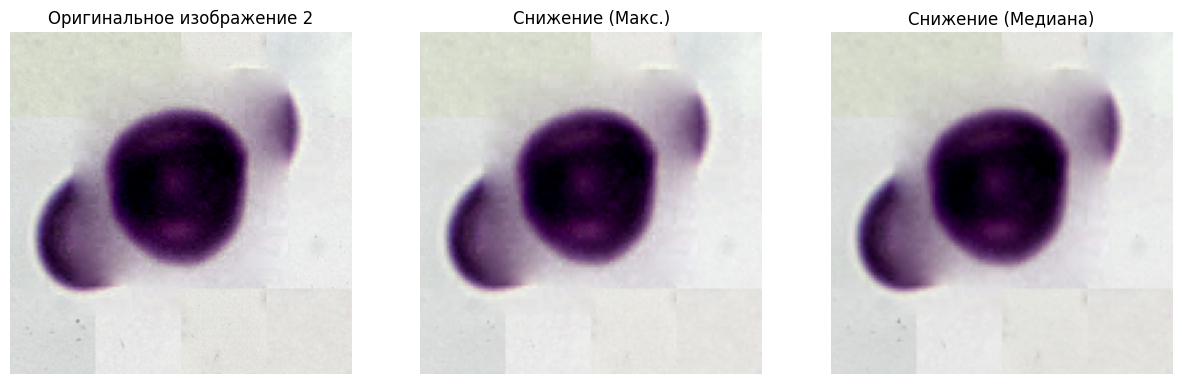

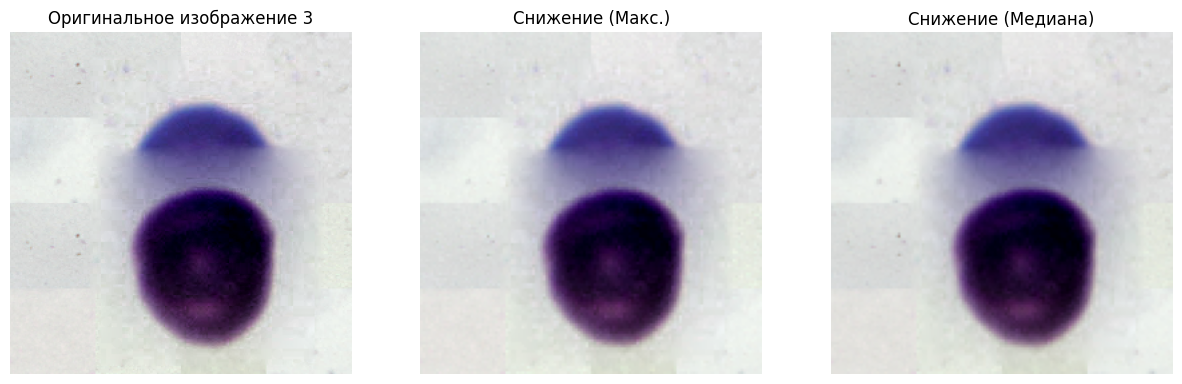

SSIM (Макс.): [0.9732649493061473, 0.9756195556867221, 0.9732298344751541]
MSE (Макс.): [11.090128580729166, 15.544942220052084, 13.58648681640625]
SSIM (Медиана): [0.9945883027541859, 0.9961065852845351, 0.9960938082092037]
MSE (Медиана): [0.6064453125, 0.5776163736979166, 0.58245849609375]


In [10]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from skimage.metrics import structural_similarity as ssim
from sklearn.metrics import mean_squared_error
import os

class ImageDownsampler:
    def __init__(self, image_folder='generated_images', image_format=".png", downsample_factor=2, num_images=3):
        self.image_folder = image_folder
        self.image_format = image_format
        self.downsample_factor = downsample_factor
        self.num_images = num_images
        self.ssim_max_values = []
        self.mse_max_values = []
        self.ssim_median_values = []
        self.mse_median_values = []
    
    def downsample_max(self, image):
        h, w, c = image.shape
        new_h = h // self.downsample_factor
        new_w = w // self.downsample_factor
        downsampled = np.zeros((new_h, new_w, c), dtype=image.dtype)
        for i in range(new_h):
            for j in range(new_w):
                block = image[i * self.downsample_factor:(i + 1) * self.downsample_factor, j * self.downsample_factor:(j + 1) * self.downsample_factor]
                downsampled[i, j] = np.max(block, axis=(0, 1)) 
        return downsampled.astype(np.uint8)
    
    def downsample_median(self, image):
        h, w, c = image.shape
        new_h = h // self.downsample_factor
        new_w = w // self.downsample_factor
        downsampled = np.zeros((new_h, new_w, c), dtype=image.dtype)
        for i in range(new_h):
            for j in range(new_w):
                block = image[i * self.downsample_factor:(i + 1) * self.downsample_factor, j * self.downsample_factor:(j + 1) * self.downsample_factor]
                downsampled[i, j] = np.median(block, axis=(0, 1))  
        return downsampled.astype(np.uint8)
    
    def process_images(self):
        for i in range(self.num_images):
            image_path = os.path.join(self.image_folder, f'clean_image_{i}{self.image_format}')
            original_image = cv2.imread(image_path)
            if original_image is None:
                print(f"Error loading image from {image_path}")
                continue
            original_image = cv2.cvtColor(original_image, cv2.COLOR_BGR2RGB) 
            downsampled_max_image = self.downsample_max(original_image.copy())
            downsampled_median_image = self.downsample_median(original_image.copy())
            
            cv2.imwrite(os.path.join(self.image_folder, f"clean_image_{i}_downsampled_max{self.image_format}"), downsampled_max_image) 
            cv2.imwrite(os.path.join(self.image_folder, f"clean_image_{i}_downsampled_median{self.image_format}"), downsampled_median_image)
            
            resized_original_image = cv2.resize(original_image, (downsampled_max_image.shape[1], downsampled_max_image.shape[0]), interpolation=cv2.INTER_LINEAR)
            self.ssim_max_values.append(ssim(resized_original_image, downsampled_max_image, channel_axis=-1, data_range=downsampled_max_image.max() - downsampled_max_image.min()))
            self.mse_max_values.append(mean_squared_error(resized_original_image.flatten(), downsampled_max_image.flatten()))
            
            self.ssim_median_values.append(ssim(resized_original_image, downsampled_median_image, channel_axis=-1, data_range=downsampled_median_image.max() - downsampled_median_image.min()))
            self.mse_median_values.append(mean_squared_error(resized_original_image.flatten(), downsampled_median_image.flatten()))
            
            self.display_images(original_image, downsampled_max_image, downsampled_median_image, i)
        
        self.print_metrics()
    
    def display_images(self, original, max_down, median_down, index):
        plt.figure(figsize=(15, 5))
        plt.subplot(1, 3, 1)
        plt.imshow(original)
        plt.title(f"Оригинальное изображение {index+1}")
        plt.axis('off')
        plt.subplot(1, 3, 2)
        plt.imshow(max_down)
        plt.title("Снижение (Макс.)")
        plt.axis('off')
        plt.subplot(1, 3, 3)
        plt.imshow(median_down)
        plt.title("Снижение (Медиана)")
        plt.axis('off')
        plt.show()
    
    def print_metrics(self):
        print("SSIM (Макс.):", self.ssim_max_values)
        print("MSE (Макс.):", self.mse_max_values)
        print("SSIM (Медиана):", self.ssim_median_values)
        print("MSE (Медиана):", self.mse_median_values)

# Использование класса
downsampler = ImageDownsampler()
downsampler.process_images()
